In [1]:
import numpy as np
import pandas as pd
import AgentClass
import const
import random
import networkx as nx
from config import num_agents,number_of_bits
from scipy import stats
from collections import defaultdict
import json
import utilities
import copy

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
from random import shuffle

from scipy.spatial import distance

In [2]:
sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)

In [3]:
def get_tau_distr():
    lower = 0
    upper = 1
    mu = 0.5
    sigma = 0.1
    N = 1000

    samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

    return samples

In [4]:
def create_environment():
    

    # bits shuffling for equal bits
    eq_bits = [[0 for i in range(num_agents//2)] + [1 for i in range(num_agents//2)] for i in range(number_of_bits)]
    for i in eq_bits:
        shuffle(i)
        
    list_agents = []
    tau_distr = get_tau_distr()
    for i in range(num_agents):

        in_state = [bit.pop() for bit in eq_bits]

        a = AgentClass.Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)

    # create network
    G = nx.newman_watts_strogatz_graph(num_agents, 5, 0.5, seed= 0)
    df = nx.to_pandas_adjacency(G, dtype=int)

    tmp_edges = df.apply(lambda row: row.to_numpy().nonzero()).to_dict()
    edges = {k: v[0].tolist() for k, v in tmp_edges.items()}

    # make random connections with agents
    for k, v in edges.items():
        for ngh in v:
            list_agents[k].add_neighbors(list_agents[ngh])

    return list_agents

In [5]:
def get_network_df(list_agents):
    network_df = pd.DataFrame({'Agent Name':[], 'Neighbors':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        network_df = network_df.append({'Agent Name':agt.name,
                                        'Neighbors':neighbors}, ignore_index=True)
    return network_df

In [6]:
def run_simulation(alpha, coherence, bit_mat, list_agents, end_time):
    d = []
    generations = 0
    for t in range(end_time):
        # compute next state for all agents
        for agt in list_agents:
            agt.update_knowledge(alpha, coherence, bit_mat)

        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Number': int(agt.name.split('t')[1]),
                   'Time':t,
                   # at any time step we will need normalized how many neighbors disagree on bits
                   'bits_disagreement':np.array(agt.state_disagreements),
                   'Current_Knowledge_State':agt.knowledge_state,
                   'Current': utilities.bool2int(agt.knowledge_state),
                   'alpha':alpha,
                   'Next': utilities.bool2int(agt.next_state),
                   'Next_Knowledge_State':agt.next_state}

            d.append(row)

        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None

        generations+=1

    return pd.DataFrame(d)

### The heatmap in the section below shows the coherence matrix with attractors and their depth and radius

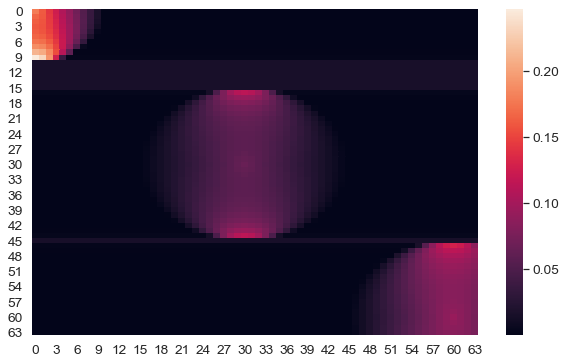

In [7]:
# define attractors
attractors = {0:{'depth': 0.9, 'radius':10}, 30:{'depth': 0.5, 'radius':15}, 60:{'depth': 0.7, 'radius':15}}
coh_mat = np.zeros((2**number_of_bits, 2**number_of_bits))


for k, v in attractors.items():
    coh_mat[k,k] = v['depth']
    r = v['radius']
    n = 2**number_of_bits
    for i in range(v['radius']):
        # get radius https://stackoverflow.com/a/8650741/5916727
        y,x = np.ogrid[-k:n-k, -k:n-k]
        mask = x*x + y*y <= r*r
        df_lists = []
        for i in range(2**number_of_bits):
            for j in range(2**number_of_bits):
            
                if mask[i,j]:
                    diff = distance.euclidean((i,j), (k,k))
                    attrctr_state_distance = (1-diff/v['radius'])*v['depth']
                    coh_mat[i, j] = max(coh_mat[i, j], attrctr_state_distance)
                    coh_mat[j, i] = max(coh_mat[j, i], attrctr_state_distance)
            

# add noise to coherence matrix:
for i, row in enumerate(coh_mat):
    for j, col in enumerate(row):
        if col == 0:
            coh_mat[i][j] += 0.001
            
    # normalizing        
    summing = sum(coh_mat[i])
    for j, col in enumerate(row):
        coh_mat[i][j] /= summing  
        
sns.heatmap(coh_mat);


In [8]:
### This cell is for generating the dataset
# constants intialization
end_simulation_time = 100
alphas = [0] 
exp_times = 1

# first create environment
agents_list = create_environment()

# get network of the agents
agent_network_df = get_network_df(agents_list)
constants = const.Constants()

coherence = coh_mat
bit_mat = constants.get_bit_matrix()

Initializing matrix using bitblock method again


In [9]:
copy_agents_list = [copy.copy(a) for a in agents_list]


### Viewing the state distribution and initial

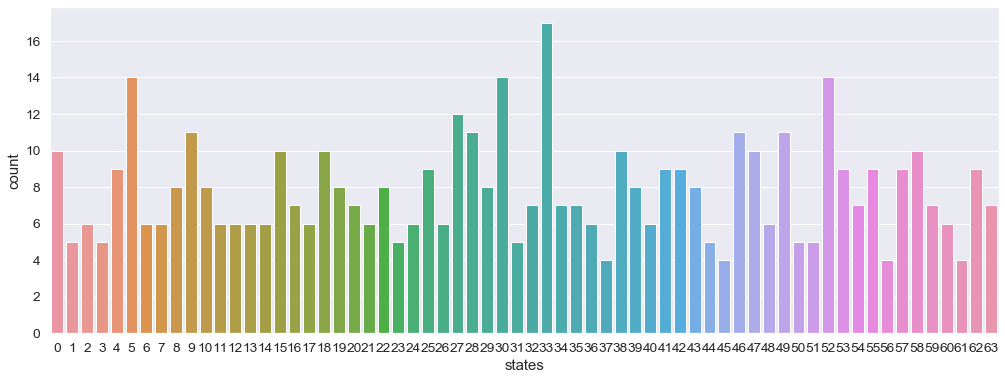

In [10]:
sns.set(style='darkgrid', rc={'figure.figsize':(17,6)}, font_scale=1.25)
initial_state_count = pd.DataFrame(pd.DataFrame([utilities.bool2int(i.knowledge_state) for i in agents_list])[0].value_counts()).reset_index()
initial_state_count.columns = ['states', 'count']
sns.barplot(x='states', y='count', data=initial_state_count);

In [11]:
record_df = pd.DataFrame()
for i in range(exp_times):
    # run simulation
    for alpha in alphas:

        tmp_record_df = run_simulation(alpha, coherence, bit_mat, agents_list, end_simulation_time)
        record_df = record_df.append(tmp_record_df)

In [12]:
record_df.head()

,Agent_Number,Current,Current_Knowledge_State,Next,Next_Knowledge_State,Time,alpha,bits_disagreement
0,0,62,"[0, 1, 1, 1, 1, 1]",58,"[0, 1, 0, 1, 1, 1]",0,0,"[0.16666666666666666, 0.5, 0.5, 0.833333333333..."
1,1,6,"[0, 1, 1, 0, 0, 0]",4,"[0, 0, 1, 0, 0, 0]",0,0,"[0.6363636363636364, 0.45454545454545453, 0.63..."
2,2,30,"[0, 1, 1, 1, 1, 0]",32,"[0, 0, 0, 0, 0, 1]",0,0,"[0.3333333333333333, 0.3333333333333333, 0.333..."
3,3,33,"[1, 0, 0, 0, 0, 1]",31,"[1, 1, 1, 1, 1, 0]",0,0,"[0.8, 0.8, 0.8, 0.4, 0.4, 1.0]"
4,4,7,"[1, 1, 1, 0, 0, 0]",2,"[0, 1, 0, 0, 0, 0]",0,0,"[0.75, 0.75, 0.5, 0.75, 0.375, 0.25]"


### Viewing the state transitions in the above coherence matrix

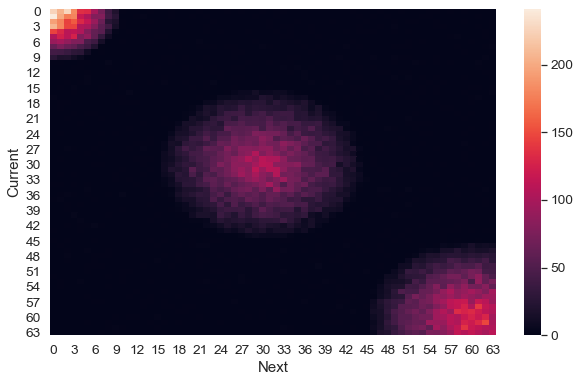

In [13]:
state_transitions = pd.crosstab(record_df['Current'], record_df['Next'])
sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)
sns.heatmap(state_transitions);

### Create different coherence matrix with less likely to flip more bits

In [14]:
# create transition matrix
transition_matrix = np.zeros((2**number_of_bits, 2**number_of_bits))

In [15]:
decay_mapper = {}
decay = 0.9
i = 1.0
for k in range(number_of_bits+1):
    decay_mapper[k] = i*decay
    decay *=0.75
print(decay_mapper)

{0: 0.9, 1: 0.675, 2: 0.5062500000000001, 3: 0.37968750000000007, 4: 0.284765625, 5: 0.21357421875000002, 6: 0.1601806640625}


In [16]:
for row_st, row in enumerate(transition_matrix):
    for col_st, col in enumerate(row):
        bits_difference = sum(np.abs(np.asarray(utilities.int2bool(row_st, number_of_bits)) - np.abs(utilities.int2bool(col_st, number_of_bits))))
        transition_matrix[row_st, col_st] = decay_mapper[bits_difference]
        
# add noise to coherence matrix:
for i, row in enumerate(transition_matrix):           
    # normalizing        
    summing = sum(transition_matrix[i])
    for j, col in enumerate(row):
        transition_matrix[i][j] /= summing  

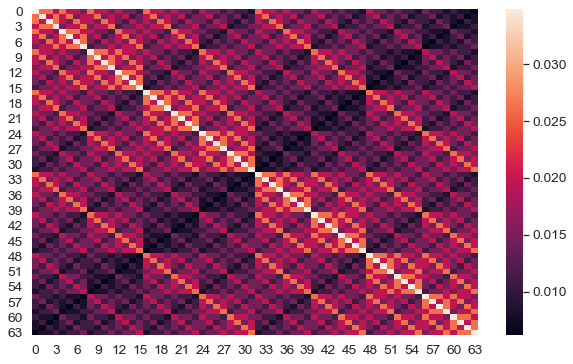

In [17]:
sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)
sns.heatmap(transition_matrix);

### Running and viewing in this coherence matrix

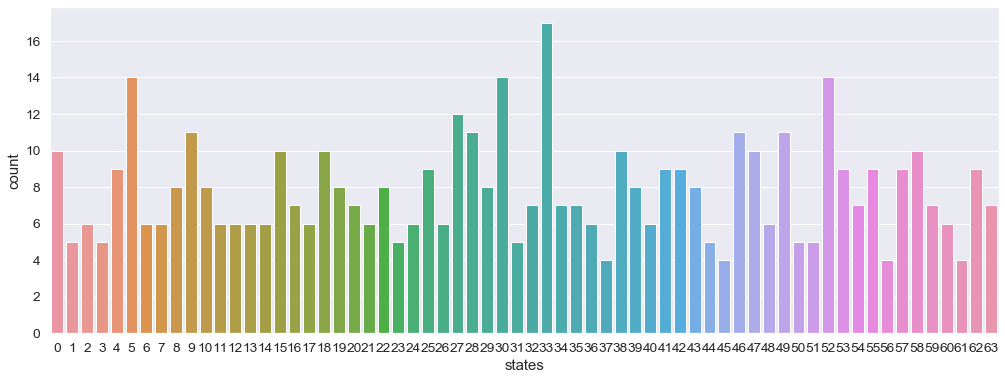

In [18]:
### This cell is for generating the dataset
# constants intialization
end_simulation_time = 100
alphas = [0] 
exp_times = 1

# first create environment
agents_list = copy_agents_list
sns.set(style='darkgrid', rc={'figure.figsize':(17,6)}, font_scale=1.25)
initial_state_count = pd.DataFrame(pd.DataFrame([utilities.bool2int(i.knowledge_state) for i in agents_list])[0].value_counts()).reset_index()
initial_state_count.columns = ['states', 'count']
sns.barplot(x='states', y='count', data=initial_state_count);

In [19]:
record_df = pd.DataFrame()
for i in range(exp_times):
    # run simulation
    for alpha in alphas:

        tmp_record_df = run_simulation(alpha, transition_matrix, bit_mat, agents_list, end_simulation_time)
        record_df = record_df.append(tmp_record_df)

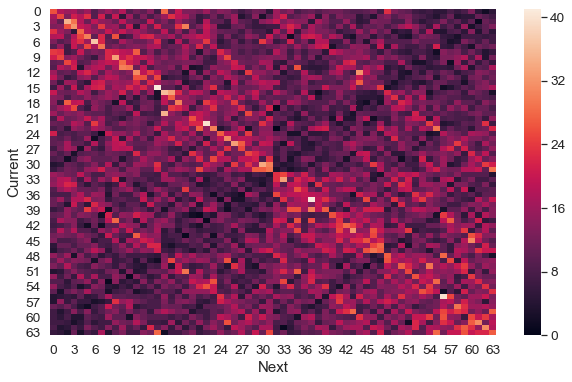

In [20]:
state_transitions = pd.crosstab(record_df['Current'], record_df['Next'])
sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)
sns.heatmap(state_transitions);